/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Epoch 1/30 - Train Loss: 1228.1317, Train Acc: 83.65% - Val Loss: 692.9673, Val Acc: 74.80%
Epoch 2/30 - Train Loss: 395.4389, Train Acc: 94.19% - Val Loss: 731.9092, Val Acc: 75.15%
Epoch 3/30 - Train Loss: 235.6207, Train Acc: 96.52% - Val Loss: 836.0720, Val Acc: 75.49%
Epoch 4/30 - Train Loss: 161.3013, Train Acc: 97.71% - Val Loss: 912.6302, Val Acc: 75.74%
Epoch 5/30 - Train Loss: 108.3093, Train Acc: 98.48% - Val Loss: 981.0129, Val Acc: 75.50%
Epoch 6/30 - Train Loss: 83.9987, Train Acc: 98.82% - Val Loss: 1035.4209, Val Acc: 74.68%
Epoch 7/30 - Train Loss: 70.3312, Train Acc: 99.03% - Val Loss: 1118.4284, Val Acc: 75.15%
Epoch 8/30 - Train Loss: 62.3831, Train Acc: 99.14% - Val Loss: 1020.8088, Val Acc: 74.95%
Epoch 9/30 - Train Loss: 51.0166, Train Acc: 99.29% - Val Loss: 1131.5584, Val Acc: 74.13%
Epoch 10/30 - Train Loss: 44.4081, Train Acc: 99.40% - Val Loss: 1190.9458, Val Acc: 74.73%
Epoch 11/30 - Train Loss: 39.4399, Train Acc: 99.45% - Val Loss: 1205.0372, Val Acc: 74.

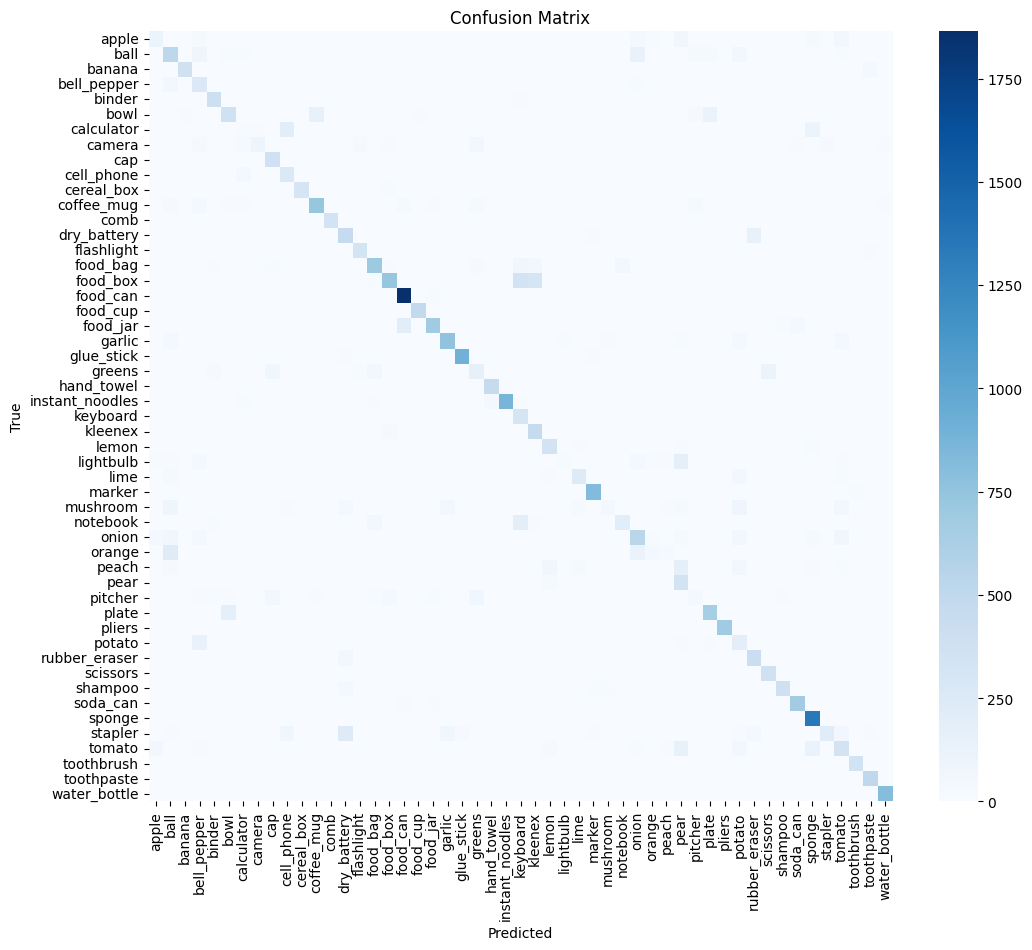

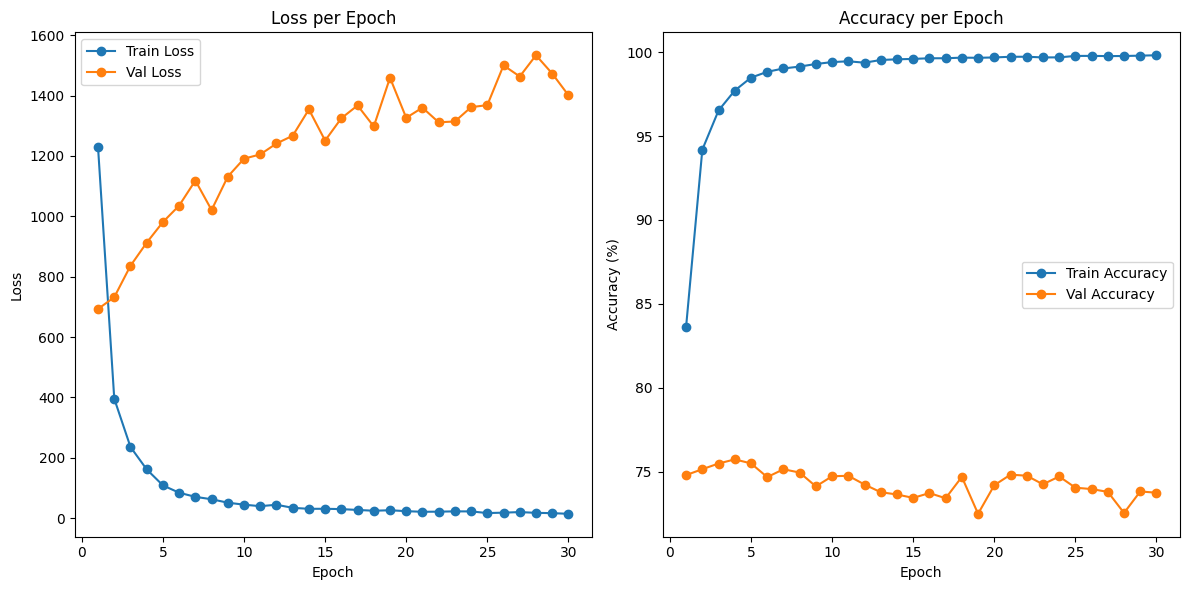

In [1]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
dataset_path = "/kaggle/input/rgb-d-cropped/rgbd-dataset_eval"
batch_size = 32
num_workers = 2
num_epochs = 30  

def load_data(dataset_path):
    instance_to_images = defaultdict(list)
    labels = dict()

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue

        for instance in os.listdir(category_path):
            instance_path = os.path.join(category_path, instance)
            if not os.path.isdir(instance_path):
                continue

            for img_name in os.listdir(instance_path):
                if img_name.endswith(".png") or img_name.endswith(".jpg"):
                    full_path = os.path.join(instance_path, img_name)
                    instance_to_images[instance].append(full_path)
                    labels[instance] = category

    return instance_to_images, labels

def split_instances(instances, labels, test_size=0.25, val_size=0.25):
    all_instances = list(instances.keys())
    all_labels = [labels[i] for i in all_instances]

    train_val_instances, test_instances = train_test_split(
        all_instances, test_size=test_size, stratify=all_labels, random_state=42)

    train_val_labels = [labels[i] for i in train_val_instances]

    train_instances, val_instances = train_test_split(
        train_val_instances, test_size=val_size, stratify=train_val_labels, random_state=42)

    return train_instances, val_instances, test_instances

class RGBDDataset(Dataset):
    def __init__(self, instances, instance_to_images, labels, transform=None):
        self.image_paths = []
        self.image_labels = []
        for inst in instances:
            for path in instance_to_images[inst]:
                self.image_paths.append(path)
                self.image_labels.append(labels[inst])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.image_labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

def prepare_dataloaders(instance_to_images, labels, splits):
    train_instances, val_instances, test_instances = splits
    le = LabelEncoder()
    le.fit([labels[i] for i in instance_to_images])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = RGBDDataset(train_instances, instance_to_images, labels, transform)
    val_dataset = RGBDDataset(val_instances, instance_to_images, labels, transform)
    test_dataset = RGBDDataset(test_instances, instance_to_images, labels, transform)

    train_dataset.image_labels = le.transform(train_dataset.image_labels)
    val_dataset.image_labels = le.transform(val_dataset.image_labels)
    test_dataset.image_labels = le.transform(test_dataset.image_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, le

def train_and_evaluate_resnet(train_loader, val_loader, test_loader, le, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss)
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    # Test performance
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))
    print("Accuracy:", accuracy_score(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting Loss and Accuracy
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Pipeline Execution
instance_to_images, labels = load_data(dataset_path)
splits = split_instances(instance_to_images, labels, test_size=0.25, val_size=0.25)
train_loader, val_loader, test_loader, le = prepare_dataloaders(instance_to_images, labels, splits)
train_and_evaluate_resnet(train_loader, val_loader, test_loader, le, num_classes=len(le.classes_))
